# Numerical Solution For Finding Langrange Multipliers

In this code we're looking at how to find the values of $\lambda_i$.

We start by defining a set of random c vectors:

In [108]:
import numpy as np
np.set_printoptions(suppress=True, precision=5)


cs = []

for i in range(10):
    cs.append(np.random.randn(7,1))

Note 'ls' is the vector of $\lambda$s:

Here are functions to calculate M, L, dL/dl, one to check the gradient (which we call at the end with a random set of ls).

Note: The functions are written to minimise $\log |M|$ (useful for using the scipy minimize function).

In [115]:
np.set_printoptions(suppress=True, precision=5)
def calcM(ls,cs):
    """
    Find the covariance matrix, M, as the lambda weighted sum of c c^T
    """
    d = len(cs[0])
    M = np.zeros([d,d])
    ccTs = []
    for l,c in zip(ls,cs):        
        ccT = np.dot(c,c.T)
        #print c,ccT,l,M
        M = M + l*ccT       
        ccTs.append(ccT)
    return M

def L(ls,cs):
    """
    Find L = -log |M| + sum(lambda_i * (1-c^T M^-1 c))
    """
    M = calcM(ls,cs)
    Minv = np.linalg.pinv(M)
    t = 0
    for l,c in zip(ls,cs):        
        t += l*(1-np.dot(np.dot(c.T,Minv),c))[0,0]

    return (-np.log(np.linalg.det(M)) + t)
    #return t

#ignore this function (it was for testing)
def shortened_L(ls,cs):
    M = calcM(ls,cs)
    return -(-np.log(np.linalg.det(M)))  

def dL_dl(ls,cs):
    """
    Find the gradient dL/dl_j
    """
    M = calcM(ls,cs)
    Minv = np.linalg.pinv(M)            
    grads = np.zeros(len(ls))    
    for j in range(len(cs)):        
        grads[j] = -np.trace(np.dot(Minv,np.dot(cs[j],cs[j].T)))     
    return np.array(grads)+1
    
def checkgrad(ls,cs):
    approx_dL_dl = []
    d = 0.0001
    for i in range(len(ls)):
        delta = np.zeros_like(ls)
        delta[i]+=d
        approx_dL_dl.append(((L(ls+delta,cs)-L(ls-delta,cs))/(2*d)))
    approx_dL_dl = np.array(approx_dL_dl)

    print "Value:"
    print L(ls,cs)
    print "Approx"
    print approx_dL_dl
    print "Analytical"
    print dL_dl(ls,cs)

    print "Difference"
    print approx_dL_dl-dL_dl(ls,cs)
    print "Ratio"
    print approx_dL_dl/dL_dl(ls,cs)

ls=np.random.rand(len(cs))

checkgrad(ls,cs)

Value:
-10.7396398724
Approx
[ 0.06063 -0.18546 -0.00892 -0.04752  0.06836  0.18628  0.51448 -0.97292
 -0.07442  0.00502]
Analytical
[ 0.06063 -0.18546 -0.00892 -0.04752  0.06836  0.18628  0.51448 -0.97292
 -0.07442  0.00502]
Difference
[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]
Ratio
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


The checkgrad function suggests the gradients are all computed correctly!

In this part I try two ways of optimising,

   1. using the scipy minimize function
   
   2. using my own optimiser

In [123]:
from scipy.optimize import minimize

def maxcMinvc(ls,cs): #this allows us to enforce a bound on the max(c^T M^-1 c) <= 1 (over all c_i)
    M = calcM(ls,cs)
    Minv = np.linalg.pinv(M)
    maxv = -np.Inf
    for l,c in zip(ls,cs):
        v = np.dot(np.dot(c.transpose(), Minv),c)
        if v>maxv:
            maxv = v
    if np.isscalar(maxv):
        return maxv
    else:
        return maxv[0,0]

print maxcMinvc(ls,cs)

def findLambdas(cs):
    ls = np.random.rand(len(cs))+0.5
    rank = np.min([len(cs),len(cs[0])])
    
    #other contstraints
    #cons = ({'type': 'eq', 'fun' : lambda ls: np.sum(ls)-rank},{'type':'ineq','fun':lambda ls:np.min(ls)})
    #cons = ({'type': 'eq', 'fun' : lambda ls: np.sum(ls)-rank},{'type':'ineq','fun':lambda ls:np.min(ls)},{'type':'ineq','fun':lambda ls:1-maxcMinvc(ls,cs)})
    cons = ({'type':'ineq','fun':lambda ls:np.min(ls)},{'type':'ineq','fun':lambda ls:1-maxcMinvc(ls,cs)})
    #cons = ()
    #res = minimize(L, ls, args=(cs), method='BFGS', options={'xtol': 1e-8, 'disp': True})
    #res = minimize(L, ls, args=(cs), method='nelder-mead', options={'xtol': 1e-8, 'disp': True})
    res = minimize(L, ls, args=(cs), method='SLSQP', options={'xtol': 1e-8, 'disp': True}, constraints=cons)
    #res = minimize(L, ls, args=(cs), method='TNC', options={'xtol': 1e-8, 'disp': True}, constraints=cons)
    #res = minimize(L, ls, args=(cs), method='TNC', options={'xtol': 1e-8, 'disp': True}, constraints=cons, jac=dL_dl)
    ls = res.x 
    return ls

ls = findLambdas(cs)
print "Lambdas:"
print ls
print np.sum(ls)

M = calcM(ls,cs)
Minv = np.linalg.pinv(M)
print "Solutions to c^T M^-1 c (should all be 0<=x<=1)"
for l,c in zip(ls,cs):
    print np.dot(np.dot(c.transpose(), Minv),c)
    

1.00000025129
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -11.3555283813
            Iterations: 9
            Function evaluations: 110
            Gradient evaluations: 9
Lambdas:
[ 0.8517   0.89403  0.99817  0.51213  0.80582  0.46354 -0.       0.9737
  0.81035  0.69055]
6.99999992445
Solutions to c^T M^-1 c (should all be 0<=x<=1)
[[ 1.]]
[[ 1.]]
[[ 1.]]
[[ 1.]]
[[ 1.]]
[[ 1.]]
[[ 0.75806]]
[[ 1.]]
[[ 1.]]
[[ 1.]]


/home/lionfish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:29: OptimizeWarning: Unknown solver options: xtol


Here's my own gradient descent method.

In [125]:
def findLambdas(cs):
    """
    Gradient descent to find the lambda_is
    
    Parameters:
        cs = list of column vectors (these are the gradients of df*/df_i)
    
    Returns:
        ls, storedls = vector of lambdas, and history of lambdas (for plotting)
        
    """
    
    ls = np.ones(len(cs))*0.7
    
    #learning rate
    lr = 0.01
    Nits = 10000
    storedls = np.zeros([Nits,len(ls)])
    for it in range(Nits): 
        delta_ls = -dL_dl(ls,cs)*lr
        ls =  ls + delta_ls
        ls[ls<0] = 0
        storedls[it,:] = ls
    return ls, storedls

ls, storedls = findLambdas(cs)       
print "Lambdas:"
print ls
M = calcM(ls,cs)
Minv = np.linalg.pinv(M)
print "Solutions to c^T M^-1 c (should all be 0<=x<=1)"
for l,c in zip(ls,cs):
    print np.dot(np.dot(c.transpose(), Minv),c)
    

Lambdas:
[ 0.8517   0.89403  0.99817  0.51213  0.80582  0.46354  0.       0.9737
  0.81035  0.69055]
Solutions to c^T M^-1 c (should all be 0<=x<=1)
[[ 1.]]
[[ 1.]]
[[ 1.]]
[[ 1.]]
[[ 1.]]
[[ 1.]]
[[ 0.75806]]
[[ 1.]]
[[ 1.]]
[[ 1.]]


Pleasingly it matches the optimiser above (which uses approximations to the gradient).

/home/lionfish/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: invalid value encountered in log


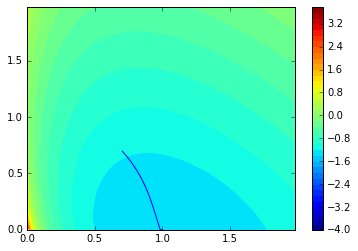

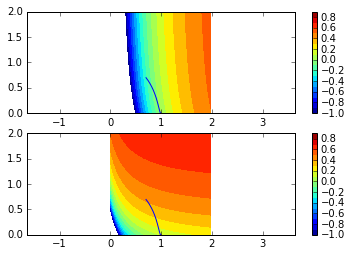

In [139]:
import matplotlib.pyplot as plt
%matplotlib inline


cs = []

for i in range(3):
    cs.append(np.random.randn(2,1))
ls, storedls = findLambdas(cs)       

other = ls[2]
xs = np.arange(0,2,0.02)
ys = np.arange(0,2,0.02)
X, Y = np.meshgrid(xs, ys)
Z = []
for xlist,ylist in zip(X,Y):
    zlist = []
    for x,y in zip(xlist,ylist):
        zlist.append(L(np.array([x,y,other]),cs))
    Z.append(zlist)
Z = np.array(Z)

CS = plt.contourf(X, Y, Z, np.arange(-4,4,0.2))
cbar = plt.colorbar(CS)
plt.plot(storedls[:,0],storedls[:,1])


storedls = np.array(storedls)
plt.figure()

for dim in range(2):
    plt.subplot(2,1,dim+1)
    Z = []
    for xlist,ylist in zip(X,Y):
        zlist = []
        for x,y in zip(xlist,ylist):
            #try:
            grad = dL_dl(np.array([x,y,other]),cs)
            zlist.append(grad[dim])
            #except:
            #    zlist.append(np.nan)

        Z.append(zlist)
    Z = np.array(Z)

    CS2 = plt.contourf(X, Y, Z, np.arange(-1,1,0.1))
    cbar = plt.colorbar(CS2)
    plt.axis('equal')
    plt.plot(storedls[:,0],storedls[:,1])
    

The top figure is the values of L (over two values of $\lambda$).
The bottom two figures are the gradients of $L$, over two values of $lambda$. The first is the gradient wrt to $lambda$ on the x-axis, and the second wrt to the one on the y-axis. So you can see how it follows the gradient down (in this case) to the maximum of $L$, but with the constraint (artificially imposed) that the lambdas must be greater than (or equal to) zero.

So in simple cases it seems to work!

I've not yet explored properly what values of $c$ cause it to fail. I'll return to examples of $c$ from real covariance functions, to investigate what structures they might have which cause a problem. I suspect it is due to many similar values of $c$ and many near-zero values, causing gradients to become flat, etc.

Hope that makes sense!

Mike.